In [1]:
# script that analyzes and computes figures for experimental data on STX1B paired with FBXO28 or VAMP2
import db_utils
import AF_plot_functions
import pandas
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import leastsq
from matplotlib import gridspec
import matplotlib
#matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
%matplotlib inline

from matplotlib.ticker import FormatStrFormatter

connect = db_utils.get_connection()
cursor = connect.cursor()

path = '/Users/luck/IMB/projects/AlphaFold/exp_data_analysis/'

In [2]:
def get_saturation_curve_data(project_id,NL_id,mCit_id,connect,FL_id):
    titration_query = f"""select a.project_id,a.NL_plasmid,a.mCit_plasmid,a.NL_property,a.mCit_property,
                c.measurement/d.measurement BRET,a.NL_plasmid_id,a.mCit_plasmid_id,a.plate_id,b.avg_FL,
                e.measurement totLu,a.well_id 
                from luthy_data.plate_layout a, luthy_data.FL_avg_points b, luthy_data.LU_raw c, 
                    luthy_data.LU_raw d, luthy_data.LU_raw e 
                where a.project_id='{project_id}' and a.include=1 and a.project_id=b.project_id and 
                    a.project_id=c.project_id and a.project_id=d.project_id and a.project_id=e.project_id and 
                    a.plate_id=b.plate_id and a.plate_id=c.plate_id and a.plate_id=d.plate_id and 
                    a.plate_id=e.plate_id and a.well_id=b.well_id and a.well_id=c.well_id and 
                    a.well_id=d.well_id and a.well_id=e.well_id and a.NL_plasmid_id='{NL_id}' and 
                    a.mCit_plasmid_id='{mCit_id}' and c.measurement_id='accLu01' and d.measurement_id='donLu01' 
                    and e.measurement_id='totLu01' and b.measurement_id='{FL_id}'"""
    bleedthrough_query = f"""select c.measurement/d.measurement bleedthrough,a.plate_id
                from luthy_data.plate_layout a, luthy_data.LU_raw c, luthy_data.LU_raw d
                where a.project_id='{project_id}' and a.include=1 and a.project_id=c.project_id and 
                    a.project_id=d.project_id and a.plate_id=c.plate_id and a.plate_id=d.plate_id and 
                    a.well_id=c.well_id and a.well_id=d.well_id and a.NL_plasmid_id='KL_03' and 
                    a.mCit_plasmid_id='empty' and c.measurement_id='accLu01' and d.measurement_id='donLu01'"""
    bkg_query = f"""select b.avg_FL bkg_FL,c.measurement bkg_LU,a.plate_id
                    from luthy_data.plate_layout a, luthy_data.FL_avg_points b, luthy_data.LU_raw c 
                    where a.project_id='{project_id}' and a.include=1 and a.project_id=b.project_id and 
                        a.project_id=c.project_id and a.plate_id=b.plate_id and a.plate_id=c.plate_id and 
                        a.well_id=b.well_id and a.well_id=c.well_id and a.NL_plasmid_id='KL_01' and 
                        a.mCit_plasmid_id='empty' and b.measurement_id='{FL_id}' and c.measurement_id='totLu01'"""

    BRET_df = pandas.read_sql(titration_query,connect)
    BT_df = pandas.read_sql(bleedthrough_query,connect)
#    print(BT_df)
    bkg_df = pandas.read_sql(bkg_query,connect)
#    print(bkg_df)
    
    BRET_df['norm_BRET'] = BRET_df['BRET'] - np.mean(list(BT_df['bleedthrough']))
    BRET_df['expr_ratio'] = (BRET_df['avg_FL'] - np.mean(list(bkg_df['bkg_FL'])))/(BRET_df['totLu'] - np.mean(list(bkg_df['bkg_LU'])))
#    print(BRET_df)
    
    return BRET_df

('KL_600', 'KL_663', 'Lu126r01', 'FL01')
('KL_600', 'KL_797', 'Lu126r01', 'FL01')
('KL_794', 'KL_663', 'Lu126r01', 'FL01')
('KL_600', 'KL_663', 'Lu129r01', 'FL01')
('KL_600', 'KL_797', 'Lu129r01', 'FL01')
('KL_794', 'KL_663', 'Lu129r01', 'FL01')
['FBXO28 - STX1B', 'FBXO28 - STX1B', 'FBXO28 - STX1B', 'FBXO28 - STX1B_L8D', 'FBXO28 - STX1B_L8D', 'FBXO28 - STX1B_L8D', 'FBXO28_L152E - STX1B', 'FBXO28_L152E - STX1B', 'FBXO28_L152E - STX1B']


/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BRET_df = pandas.read_sql(titration_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BT_df = pandas.read_sql(bleedthrough_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bkg_df = pandas.read_sql(bkg_query,connect

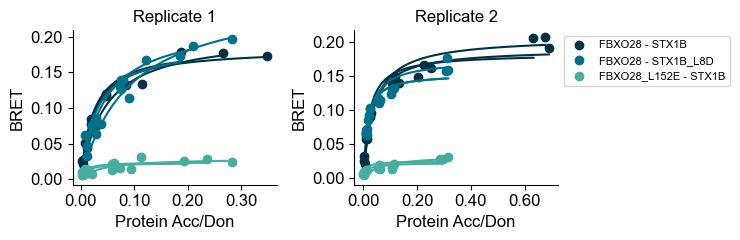

In [20]:
# plot titration curve for FBXO28 - STX1B interface between extended F box domain (63-221) and 
# N terminal peptide (1-22) of STX1B
plasmid_pair_sets = [
               [('KL_600','KL_663','Lu126r01','FL01'),('KL_600','KL_797','Lu126r01','FL01'), 
                ('KL_794','KL_663','Lu126r01','FL01')],
               [('KL_600','KL_663','Lu129r01','FL01'),('KL_600','KL_797','Lu129r01','FL01'), 
                ('KL_794','KL_663','Lu129r01','FL01')]
                    ]

labels_colors = {('KL_600','KL_663'):('FBXO28 - STX1B','#003147'),
          ('KL_600','KL_797'):('FBXO28 - STX1B_L8D','#00718B'),
          ('KL_794','KL_663'):('FBXO28_L152E - STX1B','#46AEA0')}

titles = ['Replicate 1','Replicate 2']

# create dict where data is safed
fit_dict = {}

# create df to save BRET50 and BRETmax
bret50_df = pandas.DataFrame({'pair':[],'project_id':[],'plate_id':[],'bret50':[],'bret50_err':[],'bretmax':[],
                              'bretmax_err':[],'color':[],'NL_plasmid_id':[],'mCit_plasmid_id':[]})

# create df to save BRET values and avg expression values
bret_expr_df = pandas.DataFrame({'project_id':[],'NL_plasmid':[],'mCit_plasmid':[],'NL_property':[],'mCit_property':[],
                                 'BRET':[],'NL_plasmid_id':[],'mCit_plasmid_id':[],'plate_id':[],
                                 'avg_FL':[],'totLu':[],'norm_BRET':[],'expr_ratio':[]})
#set the size of the figure plot
plt.figure(figsize=(7.5,2.5))

artist_collection = []
labels_collection = []

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,2,p+1)

    for i,plasmid_pair in enumerate(plasmid_pairs):
        print(plasmid_pair)
        pair_label = labels_colors[(plasmid_pair[0],plasmid_pair[1])][0]
        pair_color = labels_colors[(plasmid_pair[0],plasmid_pair[1])][1]
        BRET_df = get_saturation_curve_data(plasmid_pair[2],plasmid_pair[0],plasmid_pair[1],connect,plasmid_pair[3])
        BRET_df.sort_values(['plate_id','expr_ratio'],inplace=True)
#        print(BRET_df)
        bret_expr_df = bret_expr_df.append(BRET_df,ignore_index=True)
        plate_ids = list(set(list(BRET_df['plate_id'])))
#        print(plate_ids)
        
        for plate_id in plate_ids:

            sub_df = BRET_df.loc[BRET_df['plate_id']==plate_id,['expr_ratio','norm_BRET']].reset_index()
            adr_list = sub_df['expr_ratio']
            bret_list = sub_df['norm_BRET']
            # here, create lambda function to define the equation that describes the saturation curve
            func = lambda par,adr : par[0]*adr/(par[1] + adr)
            # ErrorFunc is the diference between the func and the y "experimental" data
            ErrorFunc = lambda par,adr,bret: func(par,adr)-bret
            #tplInitial contains the "first guess" of the parameters 
            Initial1 = (bret_list[len(bret_list)-1],0.01)
            # leastsq finds the parameter bret_max and kd that minimize ErrorFunc=yfit-yExperimental
            #JMS: Changed below line to output all objects from leastsq() - of interest is 'pcov'
            final,pcov,lsdict,lsmesg,success=leastsq(ErrorFunc,Initial1,args=(adr_list,bret_list),full_output=True)
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            bret_max = final[0]
            bret50 = final[1]

            # JMS: Compute std err for bret50 (according to statistical estimate of error for an estimated parameter)
            #      Calculate residual variance
            s_sq = (ErrorFunc(final,adr_list,bret_list)**2).sum()/(len(bret_list)-len(final))
            #      Multiply residual variance by fractional covariance matrix supplied by leastsq() <- this is the variance-covariance matrix
            pcov = s_sq * pcov
            #      Extract standard error: square root of values along the diagonal of variance-covariance matrix
            sterr_bret50 = (np.absolute(pcov[1][1]))**(1/2)
            sterr_bretmax = (np.absolute(pcov[0][0]))**(1/2)

            # safe data in dict
            xx1_l = xx1.tolist()
            yy1_l = yy1.tolist()
            plasmid_name = "__".join(plasmid_pair)
            data_x_y = {"experiment_name":pair_label,"data" : {"x" : xx1_l, "y": yy1_l}}
            fit_dict[plasmid_name] = data_x_y

            # plot titration curve
            line1 = plt.plot(adr_list,bret_list,linestyle='',color=pair_color,marker='o',label=pair_label)
            # plot fit line
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            plt.plot(xx1,yy1,linestyle='-',color=pair_color)

            bret50_df = bret50_df.append({'pair':pair_label,'project_id':plasmid_pair[2],'plate_id':plate_id,
                                          'bret50':bret50,'bret50_err':sterr_bret50,'bretmax':bret_max,
                                          'bretmax_err':sterr_bretmax,'color':pair_color,
                                          'NL_plasmid_id':plasmid_pair[0],'mCit_plasmid_id':plasmid_pair[1]},
                                          ignore_index=True)

    plt.title(titles[p],fontsize=12)
    plt.xlabel('Protein Acc/Don',fontsize=12)
    plt.ylabel('BRET',fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
#     plt.ylim(top=0.3)
#     plt.xlim(right=0.11)
    ax = plt.gca()
    if p == 0:
        handles, labels = ax.get_legend_handles_labels()
        artist_collection = artist_collection + handles
        labels_collection = labels_collection + labels
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    
artist_collection_final = []
labels_collection_final = []

print(labels_collection)
for i in [0,3,6]:
    artist_collection_final.append(artist_collection[i])
    labels_collection_final.append(labels_collection[i])


plt.legend(handles=artist_collection_final,labels=labels_collection_final,bbox_to_anchor=(1.0,1.0), fontsize=8)
plt.tight_layout()

df = pandas.DataFrame.from_dict(fit_dict)

plt.savefig(path+'FBXO28-Fbox-extended_STX1B-Nter_titration_indiv_Lu126r01_Lu129r01.pdf')
plt.savefig(path+'FBXO28-Fbox-extended_STX1B-Nter_titration_indiv_Lu126r01_Lu129r01.jpeg',dpi=300)
plt.show()

In [21]:
bret50_df

,pair,project_id,plate_id,bret50,bret50_err,bretmax,bretmax_err,color,NL_plasmid_id,mCit_plasmid_id
0,FBXO28 - STX1B,Lu126r01,1.0,0.045700,0.008447,0.203760,0.012487,#003147,KL_600,KL_663
1,FBXO28 - STX1B,Lu126r01,2.0,0.024051,0.002870,0.183555,0.006935,#003147,KL_600,KL_663
2,FBXO28 - STX1B,Lu126r01,3.0,0.022657,0.005396,0.184921,0.013384,#003147,KL_600,KL_663
3,FBXO28 - STX1B_L8D,Lu126r01,1.0,0.090947,0.021879,0.262965,0.027219,#00718B,KL_600,KL_797
4,FBXO28 - STX1B_L8D,Lu126r01,2.0,0.044677,0.005436,0.221446,0.010311,#00718B,KL_600,KL_797
5,FBXO28 - STX1B_L8D,Lu126r01,3.0,0.028172,0.007865,0.189285,0.017337,#00718B,KL_600,KL_797
6,FBXO28_L152E - STX1B,Lu126r01,1.0,0.037660,0.033619,0.029604,0.007841,#46AEA0,KL_794,KL_663
7,FBXO28_L152E - STX1B,Lu126r01,2.0,0.008606,0.005722,0.024059,0.003647,#46AEA0,KL_794,KL_663
8,FBXO28_L152E - STX1B,Lu126r01,3.0,0.010683,0.009699,0.023123,0.005131,#46AEA0,KL_794,KL_663
9,FBXO28 - STX1B,Lu129r01,4.0,0.031899,0.004342,0.190395,0.006359,#003147,KL_600,KL_663


('KL_600', 'KL_663', 'Lu126r01', 'FL01')
   project_id               NL_plasmid               mCit_plasmid NL_property  \
2    Lu126r01  pcDNA3.1 cmyc-NL-FBXO28  pcDNA3.1 mCit-His3C-STX1B         2ng   
8    Lu126r01  pcDNA3.1 cmyc-NL-FBXO28  pcDNA3.1 mCit-His3C-STX1B         2ng   
13   Lu126r01  pcDNA3.1 cmyc-NL-FBXO28  pcDNA3.1 mCit-His3C-STX1B         2ng   

   mCit_property    BRET NL_plasmid_id mCit_plasmid_id  plate_id  avg_FL  \
2           50ng  0.3640        KL_600          KL_663       1.0  5345.2   
8           50ng  0.3676        KL_600          KL_663       2.0  4464.8   
13          50ng  0.3739        KL_600          KL_663       3.0  4128.5   

       totLu  norm_BRET  expr_ratio well_id  
2   182353.0   0.074233    0.028408      E3  
8   214144.0   0.077833    0.019891      E3  
13  215418.0   0.084133    0.018174      E3  
('KL_600', 'KL_797', 'Lu126r01', 'FL01')
   project_id               NL_plasmid                   mCit_plasmid  \
18   Lu126r01  pcDNA3.1 cmyc-NL

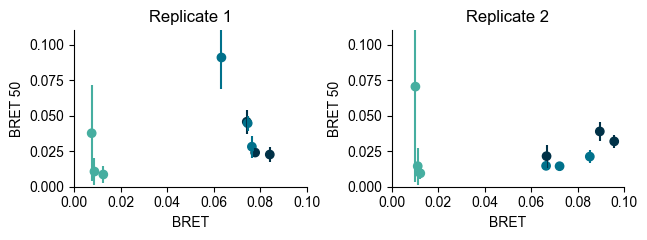

In [23]:
# plot the scatter plot BRET50 vs BRET
plt.figure(figsize=(6.5,2.5))

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,2,p+1)
    BRET_values = []
    BRET50_std = []
    BRET_50_values = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        print(plasmid_pair)
        BRET_values = BRET_values + list(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2]),'norm_BRET'])
        print(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2])])

        BRET_50_values = BRET_50_values + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'bret50'])

        BRET50_std = BRET50_std + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'bret50_err'])
 
        colors = colors + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'color'])


    print(len(BRET_values))
    print(len(BRET_50_values))
    print(len(BRET50_std))
    print(len(colors))

    plt.errorbar(BRET_values,BRET_50_values,yerr=BRET50_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(BRET_values,BRET_50_values,marker='o',color=colors)
    plt.title(titles[p],fontsize=12)
    plt.ylabel('BRET 50',fontsize=10)
    plt.xlabel('BRET',fontsize=10)
    plt.xlim((0,0.10))
    plt.ylim((0,0.11))
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.savefig(path+'FBXO28-Fbox-extended_STX1B-Nter_BRET50err_vs_BRET_Lu126r01_Lu129r01.pdf')
plt.savefig(path+'FBXO28-Fbox-extended_STX1B-Nter_BRET50err_vs_BRET_Lu126r01_Lu129r01.jpeg',dpi=300)
plt.show()

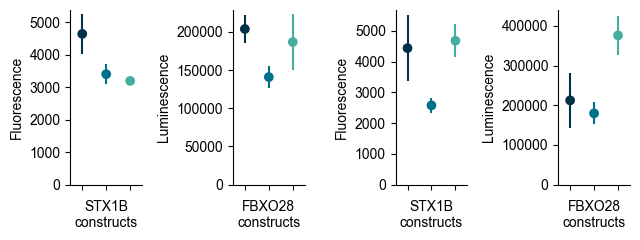

In [24]:
# plot the expression values for both partner proteins

plt.figure(figsize=(6.5,2.5))

avgFL_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['avg_FL'].aggregate(['mean','std']).reset_index()
avgLU_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['totLu'].aggregate(['mean','std']).reset_index()

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,4,p*2+1)
    FL_values = []
    FL_std = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        FL_values.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        FL_std.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'std'])[0])
 
        colors.append(labels_colors[(plasmid_pair[0],plasmid_pair[1])][1])

    plt.errorbar(range(len(FL_values)),FL_values,yerr=FL_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(FL_values)),FL_values,marker='o',color=colors)
    plt.ylabel('Fluorescence',fontsize=10)
    plt.xlabel('STX1B\nconstructs',fontsize=10)
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(FL_values)-0.5)
    plt.xticks(range(len(FL_values)),'')
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)


    plt.subplot(1,4,p*2+2)
    LU_values = []
    LU_std = []

    for plasmid_pair in plasmid_pairs:
        LU_values.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        LU_std.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'std'])[0])
 

    plt.errorbar(range(len(LU_values)),LU_values,yerr=LU_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(LU_values)),LU_values,marker='o',color=colors)
    plt.ylabel('Luminescence',fontsize=10)
    plt.xlabel('FBXO28\nconstructs',fontsize=10)
    plt.xticks(range(len(LU_values)),'')
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(LU_values)-0.5)
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

    
plt.tight_layout()
plt.savefig(path+'FBXO28-Fbox-extended_STX1B-Nter_expr_Lu126r01_Lu129r01.pdf')
plt.savefig(path+'FBXO28-Fbox-extended_STX1B-Nter_expr_Lu126r01_Lu129r01.jpeg',dpi=300)
plt.show()

('KL_600', 'KL_663', 'Lu126r01', 'FL01')
('KL_806', 'KL_663', 'Lu126r01', 'FL01')
('KL_795', 'KL_663', 'Lu126r01', 'FL01')
('KL_600', 'KL_798', 'Lu126r01', 'FL01')
('KL_600', 'KL_663', 'Lu129r01', 'FL01')
('KL_806', 'KL_663', 'Lu129r01', 'FL01')
('KL_795', 'KL_663', 'Lu129r01', 'FL01')
('KL_600', 'KL_663', 'Lu133r01', 'FL01')


/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BRET_df = pandas.read_sql(titration_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BT_df = pandas.read_sql(bleedthrough_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bkg_df = pandas.read_sql(bkg_query,connect

/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bkg_df = pandas.read_sql(bkg_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/4095666452.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bret_expr_df = bret_expr_df.append(BRET_df,ignore_index=True)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/4095666452.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bret50_df = bret50_df.append({'pair':pair_label,'project_id':plasmid_pair[2],'plate_id':plate_id,
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/4095666452

('KL_600', 'KL_798', 'Lu133r01', 'FL01')
['FBXO28 - STX1B', 'FBXO28 - STX1B', 'FBXO28 - STX1B', 'FBXO28_I355R - STX1B', 'FBXO28_I355R - STX1B', 'FBXO28_I355R - STX1B', 'FBXO28_R348L - STX1B', 'FBXO28_R348L - STX1B', 'FBXO28_R348L - STX1B', 'FBXO28 - STX1B_N134E', 'FBXO28 - STX1B_N134E', 'FBXO28 - STX1B_N134E']


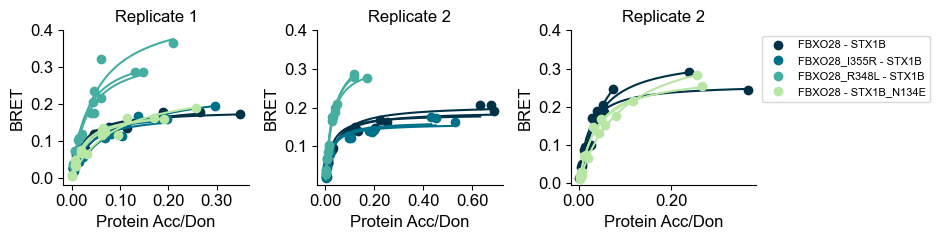

In [25]:
# plot titration curves for interface between C terminal peptide (345-363) of FBXO28 and syntaxin domain (23-237) 
# of STX1B
plasmid_pair_sets = [
               [('KL_600','KL_663','Lu126r01','FL01'), ('KL_806','KL_663','Lu126r01','FL01'),
                ('KL_795','KL_663','Lu126r01','FL01'),('KL_600','KL_798','Lu126r01','FL01')],
               [('KL_600','KL_663','Lu129r01','FL01'), ('KL_806','KL_663','Lu129r01','FL01'),
                ('KL_795','KL_663','Lu129r01','FL01')],#,('KL_600','KL_798','Lu129r01','empty')
               [('KL_600','KL_663','Lu133r01','FL01'),('KL_600','KL_798','Lu133r01','FL01')]
                    ]

labels_colors = {('KL_600','KL_663'):('FBXO28 - STX1B','#003147'),
          ('KL_806','KL_663'):('FBXO28_I355R - STX1B','#00718B'),
          ('KL_795','KL_663'):('FBXO28_R348L - STX1B','#46AEA0'),
          ('KL_600','KL_798'):('FBXO28 - STX1B_N134E','#B7E6A5')}

titles = ['Replicate 1','Replicate 2','Replicate 2']

# create dict where data is safed
fit_dict = {}

# create df to save BRET50 and BRETmax
bret50_df = pandas.DataFrame({'pair':[],'project_id':[],'plate_id':[],'bret50':[],'bret50_err':[],'bretmax':[],
                              'bretmax_err':[],'color':[],'NL_plasmid_id':[],'mCit_plasmid_id':[]})

# create df to save BRET values and avg expression values
bret_expr_df = pandas.DataFrame({'project_id':[],'NL_plasmid':[],'mCit_plasmid':[],'NL_property':[],'mCit_property':[],
                                 'BRET':[],'NL_plasmid_id':[],'mCit_plasmid_id':[],'plate_id':[],
                                 'avg_FL':[],'totLu':[],'norm_BRET':[],'expr_ratio':[]})
#set the size of the figure plot
plt.figure(figsize=(9.5,2.5))

artist_collection = []
labels_collection = []

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,3,p+1)

    for i,plasmid_pair in enumerate(plasmid_pairs):
        print(plasmid_pair)
        pair_label = labels_colors[(plasmid_pair[0],plasmid_pair[1])][0]
        pair_color = labels_colors[(plasmid_pair[0],plasmid_pair[1])][1]
        BRET_df = get_saturation_curve_data(plasmid_pair[2],plasmid_pair[0],plasmid_pair[1],connect,plasmid_pair[3])
        BRET_df.sort_values(['plate_id','expr_ratio'],inplace=True)
#        print(BRET_df)
        bret_expr_df = bret_expr_df.append(BRET_df,ignore_index=True)
        plate_ids = list(set(list(BRET_df['plate_id'])))
#        print(plate_ids)
        
        for plate_id in plate_ids:

            sub_df = BRET_df.loc[BRET_df['plate_id']==plate_id,['expr_ratio','norm_BRET']].reset_index()
            adr_list = sub_df['expr_ratio']
            bret_list = sub_df['norm_BRET']
            # here, create lambda function to define the equation that describes the saturation curve
            func = lambda par,adr : par[0]*adr/(par[1] + adr)
            # ErrorFunc is the diference between the func and the y "experimental" data
            ErrorFunc = lambda par,adr,bret: func(par,adr)-bret
            #tplInitial contains the "first guess" of the parameters 
            Initial1 = (bret_list[len(bret_list)-1],0.01)
            # leastsq finds the parameter bret_max and kd that minimize ErrorFunc=yfit-yExperimental
            #JMS: Changed below line to output all objects from leastsq() - of interest is 'pcov'
            final,pcov,lsdict,lsmesg,success=leastsq(ErrorFunc,Initial1,args=(adr_list,bret_list),full_output=True)
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            bret_max = final[0]
            bret50 = final[1]

            # JMS: Compute std err for bret50 (according to statistical estimate of error for an estimated parameter)
            #      Calculate residual variance
            s_sq = (ErrorFunc(final,adr_list,bret_list)**2).sum()/(len(bret_list)-len(final))
            #      Multiply residual variance by fractional covariance matrix supplied by leastsq() <- this is the variance-covariance matrix
            pcov = s_sq * pcov
            #      Extract standard error: square root of values along the diagonal of variance-covariance matrix
            sterr_bret50 = (np.absolute(pcov[1][1]))**(1/2)
            sterr_bretmax = (np.absolute(pcov[0][0]))**(1/2)

            # safe data in dict
            xx1_l = xx1.tolist()
            yy1_l = yy1.tolist()
            plasmid_name = "__".join(plasmid_pair)
            data_x_y = {"experiment_name":pair_label,"data" : {"x" : xx1_l, "y": yy1_l}}
            fit_dict[plasmid_name] = data_x_y

            # plot titration curve
            line1 = plt.plot(adr_list,bret_list,linestyle='',color=pair_color,marker='o',label=pair_label)
            # plot fit line
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            plt.plot(xx1,yy1,linestyle='-',color=pair_color)

            bret50_df = bret50_df.append({'pair':pair_label,'project_id':plasmid_pair[2],'plate_id':plate_id,
                                          'bret50':bret50,'bret50_err':sterr_bret50,'bretmax':bret_max,
                                          'bretmax_err':sterr_bretmax,'color':pair_color,
                                          'NL_plasmid_id':plasmid_pair[0],'mCit_plasmid_id':plasmid_pair[1]},
                                          ignore_index=True)

    plt.title(titles[p],fontsize=12)
    plt.xlabel('Protein Acc/Don',fontsize=12)
    plt.ylabel('BRET',fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(top=0.4)
#     plt.xlim(right=0.11)
    ax = plt.gca()
    if p == 0:
        handles, labels = ax.get_legend_handles_labels()
        artist_collection = artist_collection + handles
        labels_collection = labels_collection + labels
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    
artist_collection_final = []
labels_collection_final = []

print(labels_collection)
for i in [0,3,6,9]:
    artist_collection_final.append(artist_collection[i])
    labels_collection_final.append(labels_collection[i])


plt.legend(handles=artist_collection_final,labels=labels_collection_final,bbox_to_anchor=(1.0,1.0), fontsize=8)
plt.tight_layout()

df = pandas.DataFrame.from_dict(fit_dict)

plt.savefig(path+'FBXO28-Cter_STX1B-syntaxin_titration_indiv_Lu126r01_Lu129r01_Lu133r01.pdf')
plt.savefig(path+'FBXO28-Cter_STX1B-syntaxin_titration_indiv_Lu126r01_Lu129r01_Lu133r01.jpeg',dpi=300)
plt.show()


In [26]:
bret50_df

,pair,project_id,plate_id,bret50,bret50_err,bretmax,bretmax_err,color,NL_plasmid_id,mCit_plasmid_id
0,FBXO28 - STX1B,Lu126r01,1.0,0.045700,0.008447,0.203760,0.012487,#003147,KL_600,KL_663
1,FBXO28 - STX1B,Lu126r01,2.0,0.024051,0.002870,0.183555,0.006935,#003147,KL_600,KL_663
2,FBXO28 - STX1B,Lu126r01,3.0,0.022657,0.005396,0.184921,0.013384,#003147,KL_600,KL_663
3,FBXO28_I355R - STX1B,Lu126r01,1.0,0.093407,0.032695,0.255905,0.035213,#00718B,KL_806,KL_663
4,FBXO28_I355R - STX1B,Lu126r01,2.0,0.031436,0.007916,0.172768,0.013848,#00718B,KL_806,KL_663
5,FBXO28_I355R - STX1B,Lu126r01,3.0,0.021870,0.004376,0.171626,0.010042,#00718B,KL_806,KL_663
6,FBXO28_R348L - STX1B,Lu126r01,1.0,0.050080,0.020861,0.466290,0.076687,#46AEA0,KL_795,KL_663
7,FBXO28_R348L - STX1B,Lu126r01,2.0,0.032318,0.006545,0.341419,0.026318,#46AEA0,KL_795,KL_663
8,FBXO28_R348L - STX1B,Lu126r01,3.0,0.029345,0.007233,0.349052,0.032311,#46AEA0,KL_795,KL_663
9,FBXO28 - STX1B_N134E,Lu126r01,1.0,0.088078,0.030256,0.256109,0.035756,#B7E6A5,KL_600,KL_798


('KL_600', 'KL_663', 'Lu126r01', 'FL01')
   project_id               NL_plasmid               mCit_plasmid NL_property  \
2    Lu126r01  pcDNA3.1 cmyc-NL-FBXO28  pcDNA3.1 mCit-His3C-STX1B         2ng   
8    Lu126r01  pcDNA3.1 cmyc-NL-FBXO28  pcDNA3.1 mCit-His3C-STX1B         2ng   
13   Lu126r01  pcDNA3.1 cmyc-NL-FBXO28  pcDNA3.1 mCit-His3C-STX1B         2ng   

   mCit_property    BRET NL_plasmid_id mCit_plasmid_id  plate_id  avg_FL  \
2           50ng  0.3640        KL_600          KL_663       1.0  5345.2   
8           50ng  0.3676        KL_600          KL_663       2.0  4464.8   
13          50ng  0.3739        KL_600          KL_663       3.0  4128.5   

       totLu  norm_BRET  expr_ratio well_id  
2   182353.0   0.074233    0.028408      E3  
8   214144.0   0.077833    0.019891      E3  
13  215418.0   0.084133    0.018174      E3  
('KL_806', 'KL_663', 'Lu126r01', 'FL01')
   project_id                     NL_plasmid               mCit_plasmid  \
19   Lu126r01  pcDNA3.1 cmyc-

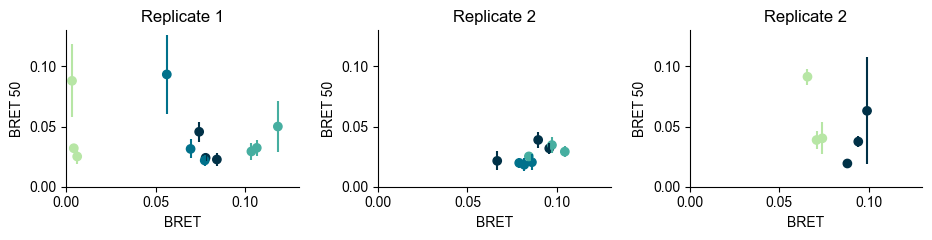

In [27]:
# plot the scatter plot BRET50 vs BRET
plt.figure(figsize=(9.5,2.5))

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,3,p+1)
    BRET_values = []
    BRET50_std = []
    BRET_50_values = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        print(plasmid_pair)
        BRET_values = BRET_values + list(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2]),'norm_BRET'])
        print(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2])])

        BRET_50_values = BRET_50_values + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'bret50'])

        BRET50_std = BRET50_std + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'bret50_err'])
 
        colors = colors + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'color'])


    print(len(BRET_values))
    print(len(BRET_50_values))
    print(len(BRET50_std))
    print(len(colors))

    plt.errorbar(BRET_values,BRET_50_values,yerr=BRET50_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(BRET_values,BRET_50_values,marker='o',color=colors)
    plt.title(titles[p],fontsize=12)
    plt.ylabel('BRET 50',fontsize=10)
    plt.xlabel('BRET',fontsize=10)
    plt.xlim((0,0.13))
    plt.ylim((0,0.13))
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.savefig(path+'FBXO28-Cter_STX1B-syntaxin_BRET50err_vs_BRET_Lu126r01_Lu129r01_Lu133r01.pdf')
plt.savefig(path+'FBXO28-Cter_STX1B-syntaxin_BRET50err_vs_BRET_Lu126r01_Lu129r01_Lu133r01.jpeg',dpi=300)
plt.show()

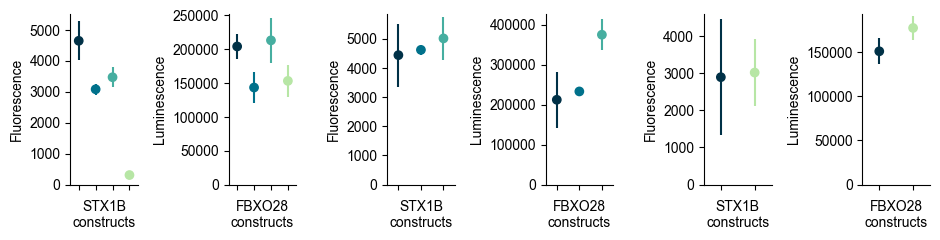

In [29]:
# plot the expression values for both partner proteins

plt.figure(figsize=(9.5,2.5))

avgFL_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['avg_FL'].aggregate(['mean','std']).reset_index()
avgLU_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['totLu'].aggregate(['mean','std']).reset_index()

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,6,p*2+1)
    FL_values = []
    FL_std = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        FL_values.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        FL_std.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'std'])[0])
 
        colors.append(labels_colors[(plasmid_pair[0],plasmid_pair[1])][1])

    plt.errorbar(range(len(FL_values)),FL_values,yerr=FL_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(FL_values)),FL_values,marker='o',color=colors)
    plt.ylabel('Fluorescence',fontsize=10)
    plt.xlabel('STX1B\nconstructs',fontsize=10)
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(FL_values)-0.5)
    plt.xticks(range(len(FL_values)),'')
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)


    plt.subplot(1,6,p*2+2)
    LU_values = []
    LU_std = []

    for plasmid_pair in plasmid_pairs:
        LU_values.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        LU_std.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'std'])[0])
 

    plt.errorbar(range(len(LU_values)),LU_values,yerr=LU_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(LU_values)),LU_values,marker='o',color=colors)
    plt.ylabel('Luminescence',fontsize=10)
    plt.xlabel('FBXO28\nconstructs',fontsize=10)
    plt.xticks(range(len(LU_values)),'')
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(LU_values)-0.5)
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

    
plt.tight_layout()
plt.savefig(path+'FBXO28-Cter_STX1B-syntaxin_expr_Lu126r01_Lu129r01_Lu133r01.pdf')
plt.savefig(path+'FBXO28-Cter_STX1B-syntaxin_expr_Lu126r01_Lu129r01_Lu133r01.jpeg',dpi=300)
plt.show()

('KL_600', 'KL_663', 'Lu126r01', 'FL01')
('KL_600', 'KL_801', 'Lu126r01', 'FL01')
('KL_793', 'KL_663', 'Lu126r01', 'FL01')
('KL_600', 'KL_663', 'Lu129r01', 'FL01')
('KL_600', 'KL_801', 'Lu129r01', 'FL01')
('KL_793', 'KL_663', 'Lu129r01', 'FL01')
('KL_600', 'KL_663', 'Lu126r01', 'FL01')
('KL_600', 'KL_804', 'Lu126r01', 'FL01')
('KL_600', 'KL_802', 'Lu126r01', 'FL01')
('KL_600', 'KL_803', 'Lu126r01', 'FL01')


/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BRET_df = pandas.read_sql(titration_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BT_df = pandas.read_sql(bleedthrough_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bkg_df = pandas.read_sql(bkg_query,connect

('KL_600', 'KL_663', 'Lu129r01', 'FL01')
('KL_600', 'KL_804', 'Lu129r01', 'FL01')
('KL_600', 'KL_802', 'Lu129r01', 'FL01')
('KL_600', 'KL_803', 'Lu129r01', 'FL01')
['FBXO28 - STX1B', 'FBXO28 - STX1B', 'FBXO28 - STX1B', 'FBXO28 - STX1B_del182-288', 'FBXO28 - STX1B_del182-288', 'FBXO28 - STX1B_del182-288', 'FBXO28_del256-333 - STX1B', 'FBXO28_del256-333 - STX1B', 'FBXO28_del256-333 - STX1B', 'FBXO28 - STX1B', 'FBXO28 - STX1B', 'FBXO28 - STX1B', 'FBXO28 - STX1B_G226R', 'FBXO28 - STX1B_G226R', 'FBXO28 - STX1B_G226R', 'FBXO28 - STX1B_S239P', 'FBXO28 - STX1B_S239P', 'FBXO28 - STX1B_S239P', 'FBXO28 - STX1B_V216E', 'FBXO28 - STX1B_V216E', 'FBXO28 - STX1B_V216E']


/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BRET_df = pandas.read_sql(titration_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BT_df = pandas.read_sql(bleedthrough_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bkg_df = pandas.read_sql(bkg_query,connect

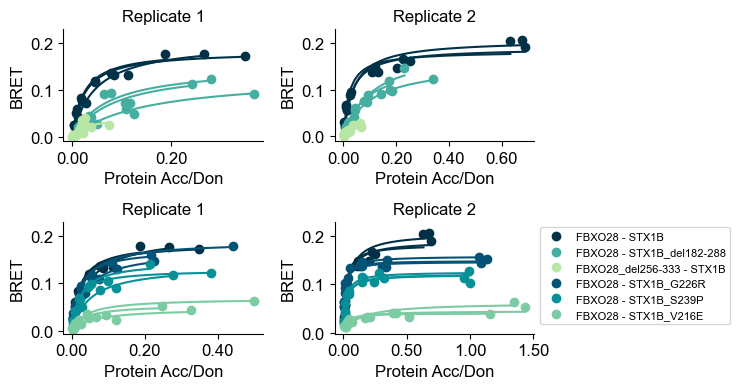

In [35]:
# aim: interface 1: Interface between long helix (258-333) and extended SNARE domain (183-287)
# make a list of PPI tuples the names of the proteins and the plasmids' ids
plasmid_pair_sets = [
               [('KL_600','KL_663','Lu126r01','FL01'),('KL_600','KL_801','Lu126r01','FL01'),
                 ('KL_793','KL_663','Lu126r01','FL01')],
               [('KL_600','KL_663','Lu129r01','FL01'),('KL_600','KL_801','Lu129r01','FL01'),
                 ('KL_793','KL_663','Lu129r01','FL01')],
               [('KL_600','KL_663','Lu126r01','FL01'),('KL_600','KL_804','Lu126r01','FL01'),
                 ('KL_600','KL_802','Lu126r01','FL01'),('KL_600','KL_803','Lu126r01','FL01')],
               [('KL_600','KL_663','Lu129r01','FL01'),('KL_600','KL_804','Lu129r01','FL01'),
                 ('KL_600','KL_802','Lu129r01','FL01'),('KL_600','KL_803','Lu129r01','FL01')]
                    ]

labels_colors = {('KL_600','KL_663'):('FBXO28 - STX1B','#003147'),
          ('KL_600','KL_804'):('FBXO28 - STX1B_G226R','#045275'),
          ('KL_600','KL_802'):('FBXO28 - STX1B_S239P','#089099'),
          ('KL_600','KL_801'):('FBXO28 - STX1B_del182-288','#46AEA0'),
          ('KL_600','KL_803'):('FBXO28 - STX1B_V216E','#7CCBA2'),
          ('KL_793','KL_663'):('FBXO28_del256-333 - STX1B','#B7E6A5')}

titles = ['Replicate 1','Replicate 2','Replicate 1','Replicate 2']

# create df to save BRET50 and BRETmax
bret50_df = pandas.DataFrame({'pair':[],'project_id':[],'plate_id':[],'bret50':[],'bret50_err':[],'bretmax':[],
                              'bretmax_err':[],'color':[],'NL_plasmid_id':[],'mCit_plasmid_id':[]})

# create df to save BRET values and avg expression values
bret_expr_df = pandas.DataFrame({'project_id':[],'NL_plasmid':[],'mCit_plasmid':[],'NL_property':[],'mCit_property':[],
                                 'BRET':[],'NL_plasmid_id':[],'mCit_plasmid_id':[],'plate_id':[],
                                 'avg_FL':[],'totLu':[],'norm_BRET':[],'expr_ratio':[]})
#set the size of the figure plot
plt.figure(figsize=(7.5,4))

artist_collection = []
labels_collection = []

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(2,2,p+1)

    for i,plasmid_pair in enumerate(plasmid_pairs):
        print(plasmid_pair)
        pair_label = labels_colors[(plasmid_pair[0],plasmid_pair[1])][0]
        pair_color = labels_colors[(plasmid_pair[0],plasmid_pair[1])][1]
        BRET_df = get_saturation_curve_data(plasmid_pair[2],plasmid_pair[0],plasmid_pair[1],connect,plasmid_pair[3])
        BRET_df.sort_values(['plate_id','expr_ratio'],inplace=True)
#        print(BRET_df)
        bret_expr_df = bret_expr_df.append(BRET_df,ignore_index=True)
        plate_ids = list(set(list(BRET_df['plate_id'])))
#        print(plate_ids)
        
        for plate_id in plate_ids:

            sub_df = BRET_df.loc[BRET_df['plate_id']==plate_id,['expr_ratio','norm_BRET']].reset_index()
            adr_list = sub_df['expr_ratio']
            bret_list = sub_df['norm_BRET']
            # here, create lambda function to define the equation that describes the saturation curve
            func = lambda par,adr : par[0]*adr/(par[1] + adr)
            # ErrorFunc is the diference between the func and the y "experimental" data
            ErrorFunc = lambda par,adr,bret: func(par,adr)-bret
            #tplInitial contains the "first guess" of the parameters 
            Initial1 = (bret_list[len(bret_list)-1],0.01)
            # leastsq finds the parameter bret_max and kd that minimize ErrorFunc=yfit-yExperimental
            #JMS: Changed below line to output all objects from leastsq() - of interest is 'pcov'
            final,pcov,lsdict,lsmesg,success=leastsq(ErrorFunc,Initial1,args=(adr_list,bret_list),full_output=True)
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            bret_max = final[0]
            bret50 = final[1]

            # JMS: Compute std err for bret50 (according to statistical estimate of error for an estimated parameter)
            #      Calculate residual variance
            s_sq = (ErrorFunc(final,adr_list,bret_list)**2).sum()/(len(bret_list)-len(final))
            #      Multiply residual variance by fractional covariance matrix supplied by leastsq() <- this is the variance-covariance matrix
            pcov = s_sq * pcov
            #      Extract standard error: square root of values along the diagonal of variance-covariance matrix
            sterr_bret50 = (np.absolute(pcov[1][1]))**(1/2)
            sterr_bretmax = (np.absolute(pcov[0][0]))**(1/2)

            # safe data in dict
            xx1_l = xx1.tolist()
            yy1_l = yy1.tolist()
            plasmid_name = "__".join(plasmid_pair)
            data_x_y = {"experiment_name":pair_label,"data" : {"x" : xx1_l, "y": yy1_l}}
            fit_dict[plasmid_name] = data_x_y

            # plot titration curve
            line1 = plt.plot(adr_list,bret_list,linestyle='',color=pair_color,marker='o',label=pair_label)
            # plot fit line
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            plt.plot(xx1,yy1,linestyle='-',color=pair_color)

            bret50_df = bret50_df.append({'pair':pair_label,'project_id':plasmid_pair[2],'plate_id':plate_id,
                                          'bret50':bret50,'bret50_err':sterr_bret50,'bretmax':bret_max,
                                          'bretmax_err':sterr_bretmax,'color':pair_color,
                                          'NL_plasmid_id':plasmid_pair[0],'mCit_plasmid_id':plasmid_pair[1]},
                                          ignore_index=True)

    plt.title(titles[p],fontsize=12)
    plt.xlabel('Protein Acc/Don',fontsize=12)
    plt.ylabel('BRET',fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(top=0.23)
#     plt.xlim(right=0.11)
    ax = plt.gca()
    if p in [0,2]:
        handles, labels = ax.get_legend_handles_labels()
        artist_collection = artist_collection + handles
        labels_collection = labels_collection + labels
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    
artist_collection_final = []
labels_collection_final = []

print(labels_collection)
for i in [0,3,6,12,15,18]:
    artist_collection_final.append(artist_collection[i])
    labels_collection_final.append(labels_collection[i])


plt.legend(handles=artist_collection_final,labels=labels_collection_final,bbox_to_anchor=(1.0,1.0), fontsize=8)
plt.tight_layout()

df = pandas.DataFrame.from_dict(fit_dict)

plt.savefig(path+'FBXO28-helix_STX1B-SNARE_titration_indiv_Lu126r01_Lu129r01.pdf')
plt.savefig(path+'FBXO28-helix_STX1B-SNARE_titration_indiv_Lu126r01_Lu129r01.jpeg',dpi=300)
plt.show()


In [36]:
bret50_df

,pair,project_id,plate_id,bret50,bret50_err,bretmax,bretmax_err,color,NL_plasmid_id,mCit_plasmid_id
0,FBXO28 - STX1B,Lu126r01,1.0,0.045700,0.008447,0.203760,0.012487,#003147,KL_600,KL_663
1,FBXO28 - STX1B,Lu126r01,2.0,0.024051,0.002870,0.183555,0.006935,#003147,KL_600,KL_663
2,FBXO28 - STX1B,Lu126r01,3.0,0.022657,0.005396,0.184921,0.013384,#003147,KL_600,KL_663
3,FBXO28 - STX1B_del182-288,Lu126r01,1.0,0.146444,0.063467,0.131075,0.027031,#46AEA0,KL_600,KL_801
4,FBXO28 - STX1B_del182-288,Lu126r01,2.0,0.086036,0.055130,0.149186,0.042834,#46AEA0,KL_600,KL_801
5,FBXO28 - STX1B_del182-288,Lu126r01,3.0,0.073159,0.030525,0.152520,0.026863,#46AEA0,KL_600,KL_801
6,FBXO28_del256-333 - STX1B,Lu126r01,1.0,0.022505,0.033109,0.040976,0.025237,#B7E6A5,KL_793,KL_663
7,FBXO28_del256-333 - STX1B,Lu126r01,2.0,0.163606,0.635939,0.194980,0.672385,#B7E6A5,KL_793,KL_663
8,FBXO28_del256-333 - STX1B,Lu126r01,3.0,0.010957,0.013204,0.036738,0.016558,#B7E6A5,KL_793,KL_663
9,FBXO28 - STX1B,Lu129r01,4.0,0.031899,0.004342,0.190395,0.006359,#003147,KL_600,KL_663


('KL_600', 'KL_663', 'Lu126r01', 'FL01')
    project_id               NL_plasmid               mCit_plasmid  \
2     Lu126r01  pcDNA3.1 cmyc-NL-FBXO28  pcDNA3.1 mCit-His3C-STX1B   
8     Lu126r01  pcDNA3.1 cmyc-NL-FBXO28  pcDNA3.1 mCit-His3C-STX1B   
13    Lu126r01  pcDNA3.1 cmyc-NL-FBXO28  pcDNA3.1 mCit-His3C-STX1B   
109   Lu126r01  pcDNA3.1 cmyc-NL-FBXO28  pcDNA3.1 mCit-His3C-STX1B   
115   Lu126r01  pcDNA3.1 cmyc-NL-FBXO28  pcDNA3.1 mCit-His3C-STX1B   
120   Lu126r01  pcDNA3.1 cmyc-NL-FBXO28  pcDNA3.1 mCit-His3C-STX1B   

    NL_property mCit_property    BRET NL_plasmid_id mCit_plasmid_id  plate_id  \
2           2ng          50ng  0.3640        KL_600          KL_663       1.0   
8           2ng          50ng  0.3676        KL_600          KL_663       2.0   
13          2ng          50ng  0.3739        KL_600          KL_663       3.0   
109         2ng          50ng  0.3640        KL_600          KL_663       1.0   
115         2ng          50ng  0.3676        KL_600          KL

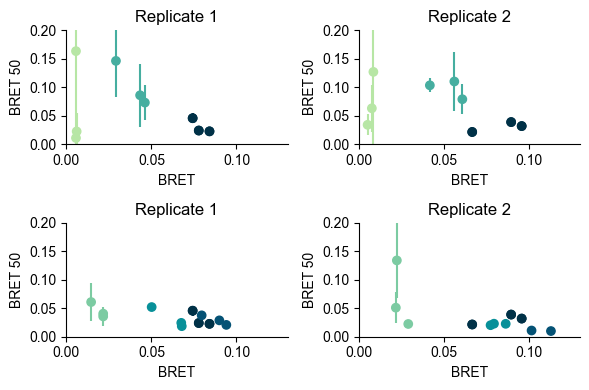

In [40]:
# plot the scatter plot BRET50 vs BRET
plt.figure(figsize=(6,4))

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(2,2,p+1)
    BRET_values = []
    BRET50_std = []
    BRET_50_values = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        print(plasmid_pair)
        BRET_values = BRET_values + list(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2]),'norm_BRET'])
        print(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2])])

        BRET_50_values = BRET_50_values + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'bret50'])

        BRET50_std = BRET50_std + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'bret50_err'])
 
        colors = colors + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'color'])


    print(len(BRET_values))
    print(len(BRET_50_values))
    print(len(BRET50_std))
    print(len(colors))

    plt.errorbar(BRET_values,BRET_50_values,yerr=BRET50_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(BRET_values,BRET_50_values,marker='o',color=colors)
    plt.title(titles[p],fontsize=12)
    plt.ylabel('BRET 50',fontsize=10)
    plt.xlabel('BRET',fontsize=10)
    plt.xlim((0,0.13))
    plt.ylim((0,0.2))
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.savefig(path+'FBXO28-helix_STX1B-SNARE_BRET50err_vs_BRET_Lu126r01_Lu129r01_Lu133r01.pdf')
plt.savefig(path+'FBXO28-helix_STX1B-SNARE_BRET50err_vs_BRET_Lu126r01_Lu129r01_Lu133r01.jpeg',dpi=300)
plt.show()

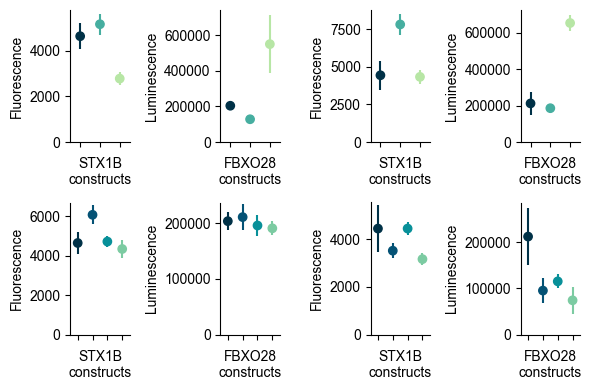

In [41]:
# plot the expression values for both partner proteins

plt.figure(figsize=(6,4))

avgFL_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['avg_FL'].aggregate(['mean','std']).reset_index()
avgLU_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['totLu'].aggregate(['mean','std']).reset_index()

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(2,4,p*2+1)
    FL_values = []
    FL_std = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        FL_values.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        FL_std.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'std'])[0])
 
        colors.append(labels_colors[(plasmid_pair[0],plasmid_pair[1])][1])

    plt.errorbar(range(len(FL_values)),FL_values,yerr=FL_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(FL_values)),FL_values,marker='o',color=colors)
    plt.ylabel('Fluorescence',fontsize=10)
    plt.xlabel('STX1B\nconstructs',fontsize=10)
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(FL_values)-0.5)
    plt.xticks(range(len(FL_values)),'')
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)


    plt.subplot(2,4,p*2+2)
    LU_values = []
    LU_std = []

    for plasmid_pair in plasmid_pairs:
        LU_values.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        LU_std.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'std'])[0])
 

    plt.errorbar(range(len(LU_values)),LU_values,yerr=LU_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(LU_values)),LU_values,marker='o',color=colors)
    plt.ylabel('Luminescence',fontsize=10)
    plt.xlabel('FBXO28\nconstructs',fontsize=10)
    plt.xticks(range(len(LU_values)),'')
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(LU_values)-0.5)
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

    
plt.tight_layout()
plt.savefig(path+'FBXO28-helix_STX1B-SNARE_expr_Lu126r01_Lu129r01_Lu133r01.pdf')
plt.savefig(path+'FBXO28-helix_STX1B-SNARE_expr_Lu126r01_Lu129r01_Lu133r01.jpeg',dpi=300)
plt.show()

('KL_596', 'KL_614', 'Lu126r01', 'FL01')
('KL_596', 'KL_614', 'Lu133r01', 'FL01')
('KL_796', 'KL_614', 'Lu126r01', 'FL01')
('KL_796', 'KL_614', 'Lu129r01', 'FL01')
['STX1B - VAMP2', 'STX1B - VAMP2', 'STX1B - VAMP2', 'STX1B - VAMP2', 'STX1B - VAMP2', 'STX1B - VAMP2', 'STX1B_del182-288 - VAMP2', 'STX1B_del182-288 - VAMP2', 'STX1B_del182-288 - VAMP2', 'STX1B_del182-288 - VAMP2', 'STX1B_del182-288 - VAMP2', 'STX1B_del182-288 - VAMP2']


/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BRET_df = pandas.read_sql(titration_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BT_df = pandas.read_sql(bleedthrough_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_12623/413438855.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bkg_df = pandas.read_sql(bkg_query,connect

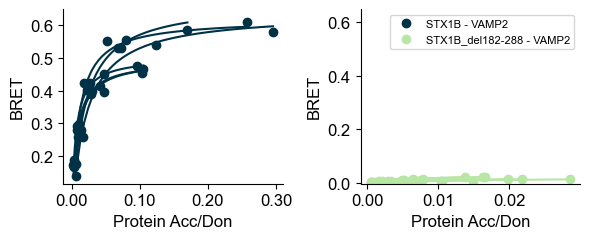

In [47]:
# make titration plot for STX1B - VAMP2 interaction
plasmid_pair_sets = [[('KL_596','KL_614','Lu126r01','FL01'),('KL_596','KL_614','Lu133r01','FL01')],
                 [('KL_796','KL_614','Lu126r01','FL01'),('KL_796','KL_614','Lu129r01','FL01')]
                ]

labels_colors = {('KL_596','KL_614'):('STX1B - VAMP2','#003147'),
          ('KL_796','KL_614'):('STX1B_del182-288 - VAMP2','#B7E6A5')}

# create df to save BRET50 and BRETmax
bret50_df = pandas.DataFrame({'pair':[],'project_id':[],'plate_id':[],'bret50':[],'bret50_err':[],'bretmax':[],
                              'bretmax_err':[],'color':[],'NL_plasmid_id':[],'mCit_plasmid_id':[]})

# create df to save BRET values and avg expression values
bret_expr_df = pandas.DataFrame({'project_id':[],'NL_plasmid':[],'mCit_plasmid':[],'NL_property':[],'mCit_property':[],
                                 'BRET':[],'NL_plasmid_id':[],'mCit_plasmid_id':[],'plate_id':[],
                                 'avg_FL':[],'totLu':[],'norm_BRET':[],'expr_ratio':[]})
#set the size of the figure plot
plt.figure(figsize=(6,2.5))

artist_collection = []
labels_collection = []

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,2,p+1)

    for i,plasmid_pair in enumerate(plasmid_pairs):
        print(plasmid_pair)
        pair_label = labels_colors[(plasmid_pair[0],plasmid_pair[1])][0]
        pair_color = labels_colors[(plasmid_pair[0],plasmid_pair[1])][1]
        BRET_df = get_saturation_curve_data(plasmid_pair[2],plasmid_pair[0],plasmid_pair[1],connect,plasmid_pair[3])
        BRET_df.sort_values(['plate_id','expr_ratio'],inplace=True)
#        print(BRET_df)
        bret_expr_df = bret_expr_df.append(BRET_df,ignore_index=True)
        plate_ids = list(set(list(BRET_df['plate_id'])))
#        print(plate_ids)
        
        for plate_id in plate_ids:

            sub_df = BRET_df.loc[BRET_df['plate_id']==plate_id,['expr_ratio','norm_BRET']].reset_index()
            adr_list = sub_df['expr_ratio']
            bret_list = sub_df['norm_BRET']
            # here, create lambda function to define the equation that describes the saturation curve
            func = lambda par,adr : par[0]*adr/(par[1] + adr)
            # ErrorFunc is the diference between the func and the y "experimental" data
            ErrorFunc = lambda par,adr,bret: func(par,adr)-bret
            #tplInitial contains the "first guess" of the parameters 
            Initial1 = (bret_list[len(bret_list)-1],0.01)
            # leastsq finds the parameter bret_max and kd that minimize ErrorFunc=yfit-yExperimental
            #JMS: Changed below line to output all objects from leastsq() - of interest is 'pcov'
            final,pcov,lsdict,lsmesg,success=leastsq(ErrorFunc,Initial1,args=(adr_list,bret_list),full_output=True)
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            bret_max = final[0]
            bret50 = final[1]

            # JMS: Compute std err for bret50 (according to statistical estimate of error for an estimated parameter)
            #      Calculate residual variance
            s_sq = (ErrorFunc(final,adr_list,bret_list)**2).sum()/(len(bret_list)-len(final))
            #      Multiply residual variance by fractional covariance matrix supplied by leastsq() <- this is the variance-covariance matrix
            pcov = s_sq * pcov
            #      Extract standard error: square root of values along the diagonal of variance-covariance matrix
            sterr_bret50 = (np.absolute(pcov[1][1]))**(1/2)
            sterr_bretmax = (np.absolute(pcov[0][0]))**(1/2)

            # safe data in dict
            xx1_l = xx1.tolist()
            yy1_l = yy1.tolist()
            plasmid_name = "__".join(plasmid_pair)
            data_x_y = {"experiment_name":pair_label,"data" : {"x" : xx1_l, "y": yy1_l}}
            fit_dict[plasmid_name] = data_x_y

            # plot titration curve
            line1 = plt.plot(adr_list,bret_list,linestyle='',color=pair_color,marker='o',label=pair_label)
            # plot fit line
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            plt.plot(xx1,yy1,linestyle='-',color=pair_color)

            bret50_df = bret50_df.append({'pair':pair_label,'project_id':plasmid_pair[2],'plate_id':plate_id,
                                          'bret50':bret50,'bret50_err':sterr_bret50,'bretmax':bret_max,
                                          'bretmax_err':sterr_bretmax,'color':pair_color,
                                          'NL_plasmid_id':plasmid_pair[0],'mCit_plasmid_id':plasmid_pair[1]},
                                          ignore_index=True)

    plt.xlabel('Protein Acc/Don',fontsize=12)
    plt.ylabel('BRET',fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(top=0.65)
#     plt.xlim(right=0.11)
    ax = plt.gca()
    if p in [0,1]:
        handles, labels = ax.get_legend_handles_labels()
        artist_collection = artist_collection + handles
        labels_collection = labels_collection + labels
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    
artist_collection_final = []
labels_collection_final = []

print(labels_collection)
for i in [0,6]:
    artist_collection_final.append(artist_collection[i])
    labels_collection_final.append(labels_collection[i])


plt.legend(handles=artist_collection_final,labels=labels_collection_final,bbox_to_anchor=(1.0,1.0), fontsize=8)
plt.tight_layout()

df = pandas.DataFrame.from_dict(fit_dict)

plt.savefig(path+'STX1B_VAMP2_titration_indiv_Lu126r01_Lu129r01_Lu133r01.pdf')
plt.savefig(path+'STX1B_VAMP2_titration_indiv_Lu126r01_Lu129r01_Lu133r01.jpeg',dpi=300)
plt.show()

In [48]:
bret50_df

,pair,project_id,plate_id,bret50,bret50_err,bretmax,bretmax_err,color,NL_plasmid_id,mCit_plasmid_id
0,STX1B - VAMP2,Lu126r01,4.0,0.005743,0.001160,0.502369,0.025641,#003147,KL_596,KL_614
1,STX1B - VAMP2,Lu126r01,5.0,0.006915,0.001269,0.491731,0.023966,#003147,KL_596,KL_614
2,STX1B - VAMP2,Lu126r01,6.0,0.007863,0.001821,0.495392,0.031308,#003147,KL_596,KL_614
3,STX1B - VAMP2,Lu133r01,1.0,0.017792,0.003894,0.672434,0.046141,#003147,KL_596,KL_614
4,STX1B - VAMP2,Lu133r01,2.0,0.020602,0.003012,0.638646,0.024971,#003147,KL_596,KL_614
5,STX1B - VAMP2,Lu133r01,3.0,0.010103,0.001528,0.618962,0.020908,#003147,KL_596,KL_614
6,STX1B_del182-288 - VAMP2,Lu126r01,4.0,0.011732,0.001481,0.040888,0.003059,#B7E6A5,KL_796,KL_614
7,STX1B_del182-288 - VAMP2,Lu126r01,5.0,0.009859,0.002003,0.035236,0.003727,#B7E6A5,KL_796,KL_614
8,STX1B_del182-288 - VAMP2,Lu126r01,6.0,0.093250,0.184106,0.146422,0.254358,#B7E6A5,KL_796,KL_614
9,STX1B_del182-288 - VAMP2,Lu129r01,1.0,0.027175,0.022710,0.031555,0.016939,#B7E6A5,KL_796,KL_614


('KL_596', 'KL_614', 'Lu126r01', 'FL01')
   project_id              NL_plasmid               mCit_plasmid NL_property  \
2    Lu126r01  pcDNA3.1 cmyc-NL-STX1B  pcDNA3.1 mCit-His3C-VAMP2         2ng   
7    Lu126r01  pcDNA3.1 cmyc-NL-STX1B  pcDNA3.1 mCit-His3C-VAMP2         2ng   
13   Lu126r01  pcDNA3.1 cmyc-NL-STX1B  pcDNA3.1 mCit-His3C-VAMP2         2ng   

   mCit_property    BRET NL_plasmid_id mCit_plasmid_id  plate_id  avg_FL  \
2           50ng  0.5856        KL_596          KL_614       4.0  1575.8   
7           50ng  0.5801        KL_596          KL_614       5.0   774.2   
13          50ng  0.5458        KL_596          KL_614       6.0  1340.8   

       totLu  norm_BRET  expr_ratio well_id  
2   118559.0   0.295833    0.011211      A3  
7    60096.0   0.290333    0.008570      A3  
13  104342.0   0.256033    0.010452      A3  
('KL_596', 'KL_614', 'Lu133r01', 'FL01')
   project_id              NL_plasmid               mCit_plasmid NL_property  \
20   Lu133r01  pcDNA3.1 cmyc

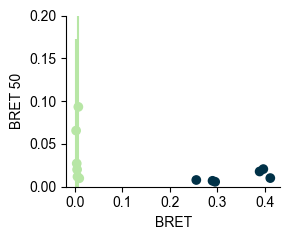

In [52]:
# plot the scatter plot BRET50 vs BRET
plt.figure(figsize=(3,2.5))

plasmid_pair_sets = [[('KL_596','KL_614','Lu126r01','FL01'),('KL_596','KL_614','Lu133r01','FL01'),
                 ('KL_796','KL_614','Lu126r01','FL01'),('KL_796','KL_614','Lu129r01','FL01')]
                ]

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,1,p+1)
    BRET_values = []
    BRET50_std = []
    BRET_50_values = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        print(plasmid_pair)
        BRET_values = BRET_values + list(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2]),'norm_BRET'])
        print(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2])])

        BRET_50_values = BRET_50_values + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'bret50'])

        BRET50_std = BRET50_std + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'bret50_err'])
 
        colors = colors + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'color'])


    print(len(BRET_values))
    print(len(BRET_50_values))
    print(len(BRET50_std))
    print(len(colors))

    plt.errorbar(BRET_values,BRET_50_values,yerr=BRET50_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(BRET_values,BRET_50_values,marker='o',color=colors)
    plt.ylabel('BRET 50',fontsize=10)
    plt.xlabel('BRET',fontsize=10)
#     plt.xlim((0,0.13))
    plt.ylim((0,0.2))
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.savefig(path+'STX1B_VAMP2_BRET50err_vs_BRET_Lu126r01_Lu129r01_Lu133r01.pdf')
plt.savefig(path+'STX1B_VAMP2_BRET50err_vs_BRET_Lu126r01_Lu129r01_Lu133r01.jpeg',dpi=300)
plt.show()

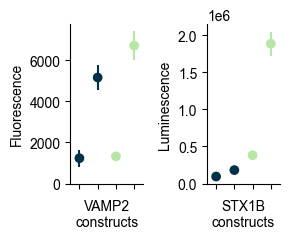

In [54]:
# plot the expression values for both partner proteins

plt.figure(figsize=(3,2.5))

avgFL_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['avg_FL'].aggregate(['mean','std']).reset_index()
avgLU_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['totLu'].aggregate(['mean','std']).reset_index()

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,2,p*2+1)
    FL_values = []
    FL_std = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        FL_values.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        FL_std.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'std'])[0])
 
        colors.append(labels_colors[(plasmid_pair[0],plasmid_pair[1])][1])

    plt.errorbar(range(len(FL_values)),FL_values,yerr=FL_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(FL_values)),FL_values,marker='o',color=colors)
    plt.ylabel('Fluorescence',fontsize=10)
    plt.xlabel('VAMP2\nconstructs',fontsize=10)
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(FL_values)-0.5)
    plt.xticks(range(len(FL_values)),'')
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)


    plt.subplot(1,2,p*2+2)
    LU_values = []
    LU_std = []

    for plasmid_pair in plasmid_pairs:
        LU_values.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        LU_std.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'std'])[0])
 

    plt.errorbar(range(len(LU_values)),LU_values,yerr=LU_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(LU_values)),LU_values,marker='o',color=colors)
    plt.ylabel('Luminescence',fontsize=10)
    plt.xlabel('STX1B\nconstructs',fontsize=10)
    plt.xticks(range(len(LU_values)),'')
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(LU_values)-0.5)
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

    
plt.tight_layout()
plt.savefig(path+'STX1B_VAMP2_expr_Lu126r01_Lu129r01_Lu133r01.pdf')
plt.savefig(path+'STX1B_VAMP2_expr_Lu126r01_Lu129r01_Lu133r01.jpeg',dpi=300)
plt.show()